# 1.8f: Black Hole Lattice Alignment Test

We have 4 black holes separated in at most 6 dimensions. **Question:** Are these separations lattice-aligned?

**Hypothesis:** If the black holes sit on a regular bfloat16 lattice, then all pairwise separations in each dimension should be integer multiples of the ULP (unit in the last place) for values at that magnitude.

**Test:**
1. Compute all 6 pairwise differences (BH1-BH2, BH1-BH3, BH1-BH4, BH2-BH3, BH2-BH4, BH3-BH4)
2. For each dimension, collect all unique separation values
3. Find the GCD (greatest common divisor) of separations
4. Compare GCD to expected bfloat16 ULP

If GCD ≈ 1 ULP → **lattice-aligned** ✓

## Parameters

In [15]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Random seed
RANDOM_SEED = 42

## Imports

In [16]:
import torch
import ml_dtypes
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from itertools import combinations
from math import gcd
from functools import reduce

## Helper Functions

In [17]:
def torch_bf16_to_numpy_bf16(tensor):
    """Convert PyTorch bfloat16 tensor to numpy array with ml_dtypes.bfloat16 dtype."""
    return tensor.cpu().view(torch.uint16).numpy().view(ml_dtypes.bfloat16)

def compute_ulp_at_value(value):
    """Compute the ULP (unit in last place) for a bfloat16 value."""
    # Convert to bfloat16
    bf16_val = ml_dtypes.bfloat16(value)
    
    # Get next representable value
    as_uint16 = np.frombuffer(bf16_val.tobytes(), dtype=np.uint16)[0]
    next_uint16 = as_uint16 + 1
    next_bf16 = np.frombuffer(next_uint16.tobytes(), dtype=ml_dtypes.bfloat16)[0]
    
    # ULP is the difference
    ulp = float(next_bf16) - float(bf16_val)
    return ulp

def float_gcd(values, tolerance=1e-12):
    """Compute GCD of floating point values by finding common divisor."""
    if len(values) == 0:
        return 0.0
    if len(values) == 1:
        return abs(values[0])
    
    # Start with smallest non-zero value
    values = [abs(v) for v in values if abs(v) > tolerance]
    if len(values) == 0:
        return 0.0
    
    min_val = min(values)
    
    # Check if all values are integer multiples of min_val
    for v in values:
        ratio = v / min_val
        if abs(ratio - round(ratio)) > tolerance:
            return None  # Not a common divisor
    
    return min_val

## Device Detection

In [18]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [19]:
# Load W in bfloat16
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]

print(f"Loaded W: {W_bf16.shape}")

Loaded W: torch.Size([151936, 2560])


In [20]:
# Load core data
core_path = Path(f"../tensors/{MODEL_NAME}/1.8a_core.safetensors")
core_data = load_file(core_path)

core_mask = core_data["core_mask"].to(torch.bool)
n_core = core_data["n_core"].item()

# Basis indices
north_idx = core_data["north_idx"].item()
meridian_idx = core_data["meridian_idx"].item()
equinox_idx = core_data["equinox_idx"].item()

print(f"Loaded core: {n_core:,} tokens")
print(f"Basis dimensions: x={meridian_idx}, y={equinox_idx}, z={north_idx}")

Loaded core: 2,179 tokens
Basis dimensions: x=322, y=1564, z=163


In [21]:
# Load black hole data
bh_path = Path(f"../tensors/{MODEL_NAME}/1.8e_black_hole_masks.safetensors")
bh_data = load_file(bh_path)

bh1_token_ids = bh_data["bh1_token_ids"].to(torch.int64)
bh2_token_ids = bh_data["bh2_token_ids"].to(torch.int64)
bh3_token_ids = bh_data["bh3_token_ids"].to(torch.int64)
bh4_token_ids = bh_data["bh4_token_ids"].to(torch.int64)
black_hole_sizes = bh_data["black_hole_sizes"].to(torch.int64)

print(f"\nLoaded black holes:")
print(f"  BH1: {len(bh1_token_ids):,} tokens")
print(f"  BH2: {len(bh2_token_ids):,} tokens")
print(f"  BH3: {len(bh3_token_ids):,} tokens")
print(f"  BH4: {len(bh4_token_ids):,} tokens")


Loaded black holes:
  BH1: 866 tokens
  BH2: 734 tokens
  BH3: 329 tokens
  BH4: 249 tokens


## Compute Core Centroid and Center Coordinates

In [22]:
print("\nComputing centered coordinates...\n")

# Extract core and center
W_core_bf16 = W_bf16[core_mask]
core_centroid_bf16 = W_core_bf16.mean(dim=0)
W_core_centered_bf16 = W_core_bf16 - core_centroid_bf16

print("✓ Computed centered coordinates in bfloat16")


Computing centered coordinates...

✓ Computed centered coordinates in bfloat16


## Get Representative Vectors for Each Black Hole

In [23]:
print("\nExtracting black hole representative vectors...\n")

# Get first token from each black hole as representative
# (all tokens in a black hole are identical in bfloat16)
bh_token_ids = [
    bh1_token_ids[0].item(),
    bh2_token_ids[0].item(),
    bh3_token_ids[0].item(),
    bh4_token_ids[0].item()
]

# Get full centered vectors for each black hole
bh_vectors_bf16 = []
for i, token_id in enumerate(bh_token_ids, 1):
    vector = W_bf16[token_id] - core_centroid_bf16
    bh_vectors_bf16.append(vector)
    print(f"BH{i}: Token {token_id}")

print(f"\n✓ Extracted {len(bh_vectors_bf16)} representative vectors")


Extracting black hole representative vectors...

BH1: Token 80091
BH2: Token 125
BH3: Token 124
BH4: Token 123939

✓ Extracted 4 representative vectors


## Compute All Pairwise Differences

In [24]:
print("\nComputing all pairwise differences...\n")

# Generate all 6 pairs
pair_indices = list(combinations(range(4), 2))
pair_labels = [(f"BH{i+1}", f"BH{j+1}") for i, j in pair_indices]

# Compute differences for all pairs
pairwise_diffs = []
for (i, j), (label_i, label_j) in zip(pair_indices, pair_labels):
    diff = bh_vectors_bf16[j] - bh_vectors_bf16[i]
    diff_np_bf16 = torch_bf16_to_numpy_bf16(diff)
    pairwise_diffs.append((label_i, label_j, diff_np_bf16))
    print(f"{label_i} → {label_j}")

print(f"\n✓ Computed {len(pairwise_diffs)} pairwise differences")


Computing all pairwise differences...

BH1 → BH2
BH1 → BH3
BH1 → BH4
BH2 → BH3
BH2 → BH4
BH3 → BH4

✓ Computed 6 pairwise differences


## Collect Separations by Dimension

In [25]:
print("\nCollecting separations by dimension...\n")

# For each dimension, collect all unique non-zero separations
dim_separations = {}  # dim -> list of separation values

for label_i, label_j, diff in pairwise_diffs:
    for dim in range(2560):
        val = float(diff[dim])
        if val != 0.0:
            if dim not in dim_separations:
                dim_separations[dim] = []
            dim_separations[dim].append(val)

# Sort dimensions by number of active dimensions
active_dims = sorted(dim_separations.keys())

print(f"Found {len(active_dims)} dimensions with non-zero separations")
print(f"Active dimensions: {active_dims}")



Found 10 dimensions with non-zero separations
Active dimensions: [216, 282, 322, 1008, 1272, 1382, 1487, 1564, 2040, 2079]


## Test Lattice Alignment: Compute GCD per Dimension

In [26]:
print("\nTesting lattice alignment...\n")
print("=" * 80)

lattice_results = []

for dim in active_dims:
    separations = dim_separations[dim]
    unique_seps = sorted(set([abs(s) for s in separations]))
    
    # Compute GCD of separations
    gcd_val = float_gcd(unique_seps)
    
    # Compute expected ULP at typical value in this dimension
    typical_val = np.mean([abs(s) for s in separations])
    expected_ulp = compute_ulp_at_value(typical_val)
    
    # Check if GCD is an integer multiple of ULP
    if gcd_val is not None:
        ratio = gcd_val / expected_ulp
        # Lattice-aligned if ratio is close to ANY integer (not just 1)
        is_lattice_aligned = abs(ratio - round(ratio)) < 0.01
    else:
        ratio = None
        is_lattice_aligned = False
    
    lattice_results.append({
        'dim': dim,
        'n_pairs': len(separations),
        'unique_seps': unique_seps,
        'gcd': gcd_val,
        'expected_ulp': expected_ulp,
        'ratio': ratio,
        'lattice_aligned': is_lattice_aligned
    })
    
    # Print result
    basis_marker = " ← BASIS" if dim in [meridian_idx, equinox_idx, north_idx] else ""
    print(f"\nDimension {dim}{basis_marker}")
    print(f"  Pairs with non-zero separation: {len(separations)}")
    print(f"  Unique separations: {len(unique_seps)}")
    for sep in unique_seps:
        print(f"    {sep:+.6e}")
    
    if gcd_val is not None:
        print(f"  GCD: {gcd_val:.6e}")
        print(f"  Expected ULP: {expected_ulp:.6e}")
        print(f"  Ratio (GCD/ULP): {ratio:.3f}")
        
        if is_lattice_aligned:
            print(f"  ✓ LATTICE-ALIGNED (GCD = {round(ratio):.0f} ULP)")
        else:
            print(f"  ✗ Not lattice-aligned (GCD = {ratio:.1f} ULP, not integer)")
    else:
        print(f"  ✗ No common divisor found")

print("\n" + "=" * 80)


Testing lattice alignment...


Dimension 216
  Pairs with non-zero separation: 3
  Unique separations: 1
    +7.629395e-06
  GCD: 7.629395e-06
  Expected ULP: 5.960464e-08
  Ratio (GCD/ULP): 128.000
  ✓ LATTICE-ALIGNED (GCD = 128 ULP)

Dimension 282
  Pairs with non-zero separation: 3
  Unique separations: 1
    +1.525879e-05
  GCD: 1.525879e-05
  Expected ULP: 1.192093e-07
  Ratio (GCD/ULP): 128.000
  ✓ LATTICE-ALIGNED (GCD = 128 ULP)

Dimension 322 ← BASIS
  Pairs with non-zero separation: 4
  Unique separations: 1
    +3.051758e-05
  GCD: 3.051758e-05
  Expected ULP: 2.384186e-07
  Ratio (GCD/ULP): 128.000
  ✓ LATTICE-ALIGNED (GCD = 128 ULP)

Dimension 1008
  Pairs with non-zero separation: 3
  Unique separations: 1
    +2.980232e-08
  GCD: 2.980232e-08
  Expected ULP: 2.328306e-10
  Ratio (GCD/ULP): 128.000
  ✓ LATTICE-ALIGNED (GCD = 128 ULP)

Dimension 1272
  Pairs with non-zero separation: 4
  Unique separations: 1
    +9.536743e-07
  GCD: 9.536743e-07
  Expected ULP: 7.450581e-

## Summary Statistics

In [27]:
print("\n" + "=" * 80)
print("SUMMARY: LATTICE ALIGNMENT TEST")
print("=" * 80)
print()

n_lattice_aligned = sum(1 for r in lattice_results if r['lattice_aligned'])
n_total = len(lattice_results)

print(f"Active dimensions: {n_total}")
print(f"Lattice-aligned dimensions: {n_lattice_aligned} ({n_lattice_aligned/n_total*100:.1f}%)")
print()

if n_lattice_aligned == n_total:
    print("RESULT: ALL separations are lattice-aligned")
    print("  → Black holes sit on a perfect bfloat16 lattice")
    print("  → All separations are integer multiples of ULP")
elif n_lattice_aligned > 0:
    print(f"RESULT: PARTIAL lattice alignment ({n_lattice_aligned}/{n_total} dimensions)")
    print("  → Some dimensions show perfect lattice structure")
    print("  → Others may have noise or sub-ULP variations")
else:
    print("RESULT: NO clear lattice alignment detected")
    print("  → Separations do not follow integer ULP multiples")

print()
print("=" * 80)


SUMMARY: LATTICE ALIGNMENT TEST

Active dimensions: 10
Lattice-aligned dimensions: 10 (100.0%)

RESULT: ALL separations are lattice-aligned
  → Black holes sit on a perfect bfloat16 lattice
  → All separations are integer multiples of ULP



## Visualize Separation Multiples


Visualizing separation multiples...



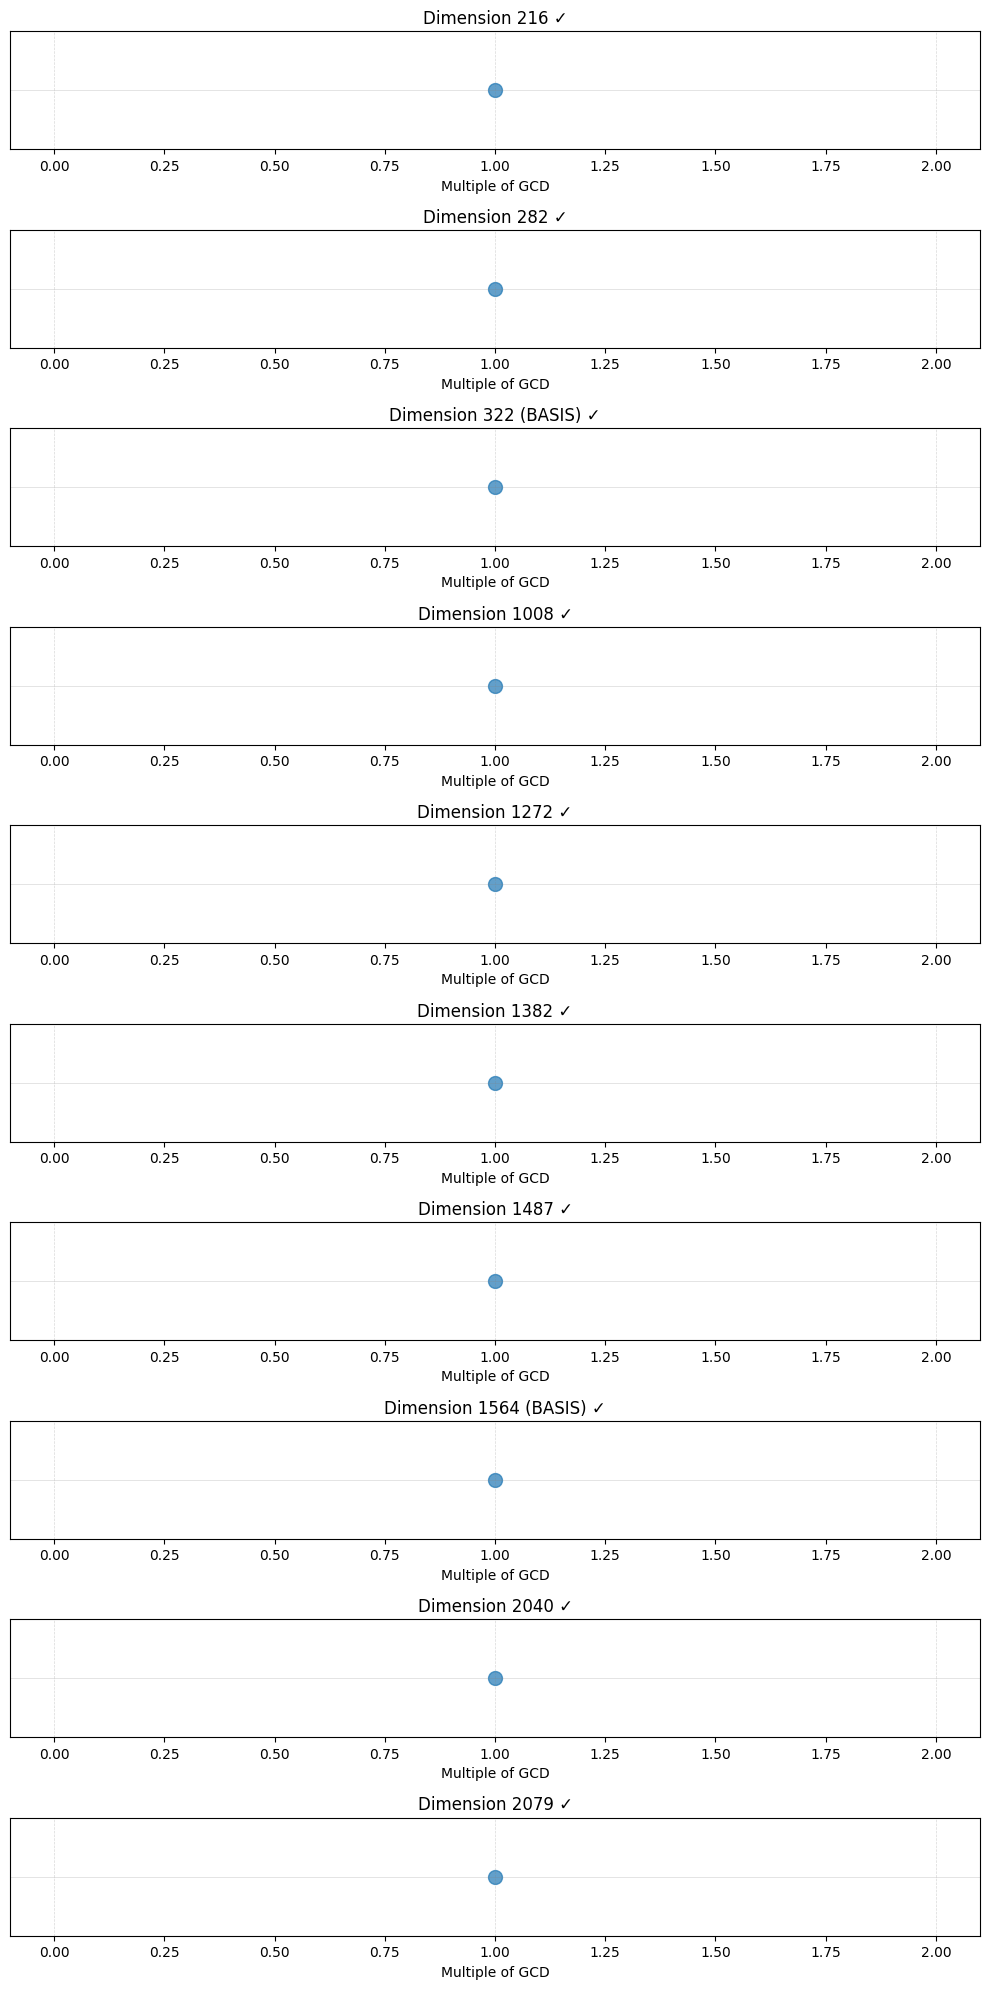

✓ Visualization complete


In [30]:
print("\nVisualizing separation multiples...\n")

# For each dimension, plot separations as multiples of GCD
fig, axes = plt.subplots(len(active_dims), 1, figsize=(10, 2 * len(active_dims)), dpi=100)

if len(active_dims) == 1:
    axes = [axes]

for idx, (ax, result) in enumerate(zip(axes, lattice_results)):
    dim = result['dim']
    unique_seps = result['unique_seps']
    gcd_val = result['gcd']
    expected_ulp = result['expected_ulp']
    
    # Compute multiples of GCD
    if gcd_val is not None and gcd_val > 0:
        multiples = [sep / gcd_val for sep in unique_seps]
    else:
        multiples = unique_seps
    
    # Plot
    ax.scatter(multiples, [0] * len(multiples), s=100, alpha=0.7)
    ax.set_yticks([])
    ax.set_xlabel('Multiple of GCD')
    
    basis_marker = " (BASIS)" if dim in [meridian_idx, equinox_idx, north_idx] else ""
    aligned_marker = " ✓" if result['lattice_aligned'] else ""
    ax.set_title(f"Dimension {dim}{basis_marker}{aligned_marker}")
    
    # Add grid at integer multiples
    if gcd_val is not None:
        ax.axhline(0, color='gray', linewidth=0.5, alpha=0.3)
        max_mult = max(multiples) if multiples else 1
        for i in range(int(max_mult) + 2):
            ax.axvline(i, color='gray', linewidth=0.5, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualization complete")